# Анализ воронки событий и А/А/В-теста

# Введение

В данном исследовании мы изучим поведение пользователей мобильного приложения, составим и проанализируем воронку событий, а так же определимся с результатами А/А/В-теста \
\
Определим несколько **целей** данного исследования: 
1) Составить и изучить воронку событий, определив конверсию на каждом шаге 
2) Изучить и проанализировать результата А/А/В-теста 
\
В нашем распоряжении данные о всех событиях, через которые проходят пользователи. Также в данных хранится информация какой пользователей принадлежит к какой контрольной группе 
\
**План работы:** 
1) Изучить и обработать данные, избавившись от проблем и ошибок в данных и подготовить их к дальнейшему анализу 
2) Посчитать, сколько пользователей совершали какое-либо из событий 
3) Определить долю пользователей, перешедших на каждый последующий шаг воронки событий 
4) Проверить, равны ли группы А/А между собой 
5) Найти статистически значимые различия или их отсутствие между группой с измененным шрифтом и двумя другими контрольными группами

# Предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
import plotly.express as px

In [3]:
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
data.columns = (['event_name', 'device_id_hash', 'events_timestamp', 'exp_id']) # переименование столбцов

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   event_name        244126 non-null  object
 1   device_id_hash    244126 non-null  int64 
 2   events_timestamp  244126 non-null  int64 
 3   exp_id            244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Тип данных во всех столбцах верный. Столбец `events_timestamp` отражает число секунд по стандарту UTC

In [6]:
data.isna().sum()

event_name          0
device_id_hash      0
events_timestamp    0
exp_id              0
dtype: int64

Пропусков в данных нет

Добавим столбец с датой и временем, переведя их из формата UTC столбца `events_timestamp`

In [7]:
data['date_time'] = pd.to_datetime(data['events_timestamp'], unit='s')
data['date'] = data['date_time'].dt.date
data['date'] = pd.to_datetime(data['date'], format='%Y.%m.%d') # приводим столбец к формату datetime

In [8]:
data.head()

,event_name,device_id_hash,events_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [9]:
data.duplicated().sum()

413

В данных обнаружились 413 дубликатов. Поскольку с одного устройства в один момент времени участник одной и той же группы не может совершить несколько одинаковых событий, дубликаты являются нарушениями данных и нуждаются в удалении

In [10]:
data = data.drop_duplicates().reset_index(drop= True)

In [11]:
data.duplicated().sum()

0

Мы избавились от дубликатов

In [12]:
data['exp_id'].unique()

array([246, 248, 247], dtype=int64)

Контрольных групп в данных всего три, как и должно быть в нашем А/А/В-тесте

# Основная часть

## Изучение и проверка данных

### Сколько всего событий в логе?

In [13]:
print(data['event_name'].count())
pd.DataFrame(data['event_name'].unique())

243713


,0
0,MainScreenAppear
1,PaymentScreenSuccessful
2,CartScreenAppear
3,OffersScreenAppear
4,Tutorial


Всего в данных хранится информация о 243 713 событиях, которые поделены на 5 типов

### Сколько всего пользователей в логе?

In [14]:
pd.DataFrame(data['device_id_hash'].unique())

,0
0,4575588528974610257
1,7416695313311560658
2,3518123091307005509
3,6217807653094995999
4,8351860793733343758
...,...
7546,5811573131275421338
7547,5365227480683749189
7548,6660805781687343085
7549,7823752606740475984


In [15]:
data.groupby('device_id_hash').agg({'exp_id' : 'nunique'}).query('exp_id>1').count()

exp_id    0
dtype: int64

В данных 7551 уникальных хэш устройств, что можно считать уникальными пользователями, поскольку с помощью дополнительной проверки мы убедились, что ни одно устройство не было в двух или более группах эксперимента одновременно.

### Сколько в среднем событий приходится на пользователя?

In [16]:
data['event_name'].count() / pd.DataFrame(data['device_id_hash'].unique()).count()

0    32.275593
dtype: float64

В среднем на одного пользователя приходится чуть больше 32 событий

### Данными за какой период мы располагаем?

In [17]:
print("Начало периода:", data['date'].min())
print('Конец периода:', data['date'].max())

Начало периода: 2019-07-25 00:00:00
Конец периода: 2019-08-07 00:00:00


В данных содержится информация о периоде с 25-го июня по 7-е августа 2019 года (14 дней)

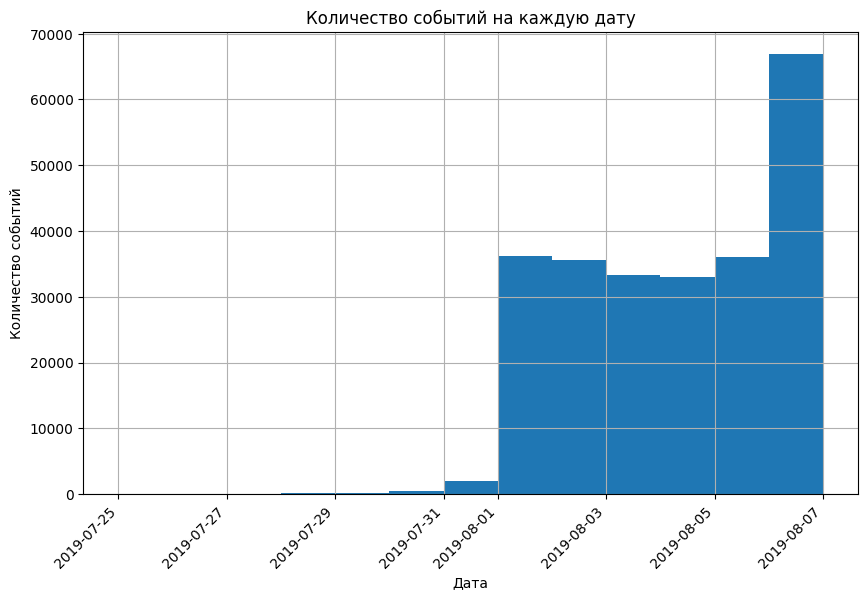

In [18]:
plt.figure(figsize=(10, 6))
data['date'].hist(bins=13)
plt.title('Количество событий на каждую дату')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45, ha='right')
plt.show()

Как мы видим. в данных почти остутсвует информация о событиях за первую неделю периода (с 25 по 31 июля), поэтому для дальнейшего анализа мы будем использовать только период с 1 по 7 августа

In [19]:
original_data = data

In [20]:
data = data.query('date >= "2019-08-01"')
data

,event_name,device_id_hash,events_timestamp,exp_id,date_time,date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [21]:
deleted_data = original_data.loc[~original_data.index.isin(data.index)]
print('Потеряно пользователей после очистки:', deleted_data['device_id_hash'].nunique())
print('Процент потерянных пользователей:', (deleted_data['device_id_hash'].nunique() / data['device_id_hash'].nunique() * 100))

Потеряно пользователей после очистки: 1451
Процент потерянных пользователей: 19.25935757897531


In [22]:
# код ревьюера
print('Событий было: ', original_data.shape[0])
print('Пользователей было: ',original_data['device_id_hash'].nunique())
print('Событий после того как отбросили данные: ', data.shape[0])
print('Пользователей после того как отбросили данные: ',data['device_id_hash'].nunique())
print('Изменение количества событий: ''{:.1%}'.format((data.shape[0]-original_data.shape[0])/original_data.shape[0]))
print('Изменение количества пользователей: ''{:.1%}'.format((data['device_id_hash'].nunique()-original_data['device_id_hash'].nunique())/original_data['device_id_hash'].nunique()))





Событий было:  243713
Пользователей было:  7551
Событий после того как отбросили данные:  240887
Пользователей после того как отбросили данные:  7534
Изменение количества событий: -1.2%
Изменение количества пользователей: -0.2%


In [23]:
print('Потеряно строк при очистке:', deleted_data['device_id_hash'].count())
print('Процент потерянных строк:', deleted_data['device_id_hash'].count() / data['device_id_hash'].count() * 100)
print('Потери строк по категориям событий:')
pd.DataFrame(deleted_data.groupby('event_name')['device_id_hash'].count()).sort_values(by='device_id_hash', ascending=False)

Потеряно строк при очистке: 2826
Процент потерянных строк: 1.1731641807154392
Потери строк по категориям событий:


,device_id_hash
event_name,
MainScreenAppear,1773
OffersScreenAppear,475
CartScreenAppear,365
PaymentScreenSuccessful,200
Tutorial,13


После очистки данных, мы потеряли 2826 записей о событиях (примерно 1,2% от изначального объема), среди которых было 1451 уникальный пользователь (примерно 19% изначального количества)

### Проверка наличия пользователей из всех трез групп

In [24]:
groups_total = pd.DataFrame(data.groupby('exp_id')['device_id_hash'].agg('nunique'))
groups_total['ratio in %'] = ((groups_total['device_id_hash'] / groups_total['device_id_hash'].sum()) * 100).round(2)
groups_total

,device_id_hash,ratio in %
exp_id,,
246,2484,32.97
247,2513,33.36
248,2537,33.67


В данных присутствуют пользователи из всех трех групп, причем распределены они равномерно

## Изучение воронки событий

### Изучение событий в логах и их частоту

In [25]:
pd.DataFrame(data.groupby('event_name')['device_id_hash'].count()).sort_values(by='device_id_hash', ascending=False)

,device_id_hash
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


В данных присутствует 5 типов событий: чаще всего происходит событие "Появление главного экрана", после него идут соответсвенно "Экран с предложениями", "Корзина", "Экран успешной оплаты" и "Обучение". 

### Подсчет количества пользователей, совершавших каждое из действий

In [26]:
events_table = pd.DataFrame(data.groupby('event_name')['device_id_hash'].agg('nunique')).sort_values(by='device_id_hash', ascending=False)
events_table['conversion in %'] = (events_table['device_id_hash'] / data['device_id_hash'].agg('nunique') * 100).round(2)
events_table

,device_id_hash,conversion in %
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


Обучение прошли всего 11 процентов всех пользователей, поэтому его мы точно определяем вне воронки событий. \
Остальные события входят в последовательную ворону: Гравный экран -> Экран с предложениями -> Корзина -> Экран успешной оплаты \
Стоит отметить, что конверсия на первом шаге воронки в 98,4% отражает наличие в данных остатков после фильтрации, а именно пользователей, которые зашли в приложение до 1 августа, а совершили дальшейние действия после

In [27]:
funnel_events = events_table.query('event_name != "Tutorial"')
funnel_events

,device_id_hash,conversion in %
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97


### Подсчет доли пользователей, проходящих на следующий шаг воронки

In [28]:
pd.options.mode.chained_assignment = None # отключаем показ предупреждения
conversion_funnel = []
conversion_funnel.append(100)
for i in range(1, len(funnel_events)):
    conversion = ((funnel_events['device_id_hash'].iloc[i] / funnel_events['device_id_hash'].iloc[i-1]) * 100).round(2)
    conversion_funnel.append(conversion)
funnel_events['conversion_by_step in %'] = conversion_funnel
funnel_events

,device_id_hash,conversion in %,conversion_by_step in %
event_name,,,
MainScreenAppear,7419,98.47,100.00
OffersScreenAppear,4593,60.96,61.91
CartScreenAppear,3734,49.56,81.30
PaymentScreenSuccessful,3539,46.97,94.78


61,9% пользователей переходят с Главного экрана на экран Предложений. Из них 81% переходит в Корзину, и уже 94% из перешедших в Корзину успешно совершают оплату. \
Больше всего пользователей мы теряем на этапе перехода с Главного экрана на экран Предложений \
В целом почти 47% пользователей проходят все шаги воронки от попадания на Главный экран до совершения оплаты

## Анализ результатов эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [30]:
groups_total

,device_id_hash,ratio in %
exp_id,,
246,2484,32.97
247,2513,33.36
248,2537,33.67


Как уже упоминалось ранее, число пользователей в трех группах практически одинаково

### Находят ли статистические критерии разницу между выборками 246 и 247

В качестве **нулевой гипотезы** предположим, что группы равны \
Таким образом **альтернативная гипотеза** будет заключаться в том, что группы не равны между собой

В качестве критического уровня статистической значимости (alpha), мы использовали поправку по методу Шидака, определив alpha по формуле **1-(1-0.05)^(1/16)**, поскольку нам предстоит совершить проверку 16-ти гипотез при сравнении групп 246, 247, 248 между собой и группу 248 со скомбинированными данными по 246 и 247 группе по каждому из событий (их 4)

In [31]:
def compare_groups(original_data, event, group_1, group_2, group_3):
    alpha = 1-(1-0.05)**(1/16)
    if group_3 != 248:
        successes_1 = original_data.query('exp_id == @group_1 and event_name == @event')['device_id_hash'].nunique()
        successes_2 = original_data.query('exp_id == @group_2 and event_name == @event')['device_id_hash'].nunique()
        successes = np.array([successes_1, successes_2])
        trials_1 = original_data.query('exp_id == @group_1')['device_id_hash'].nunique()
        trials_2 = original_data.query('exp_id == @group_2')['device_id_hash'].nunique()
        trials = np.array([trials_1, trials_2])
    else:
        successes_1 = original_data.query('exp_id != @group_3 and event_name == @event')['device_id_hash'].nunique()
        successes_2 = original_data.query('exp_id == @group_3 and event_name == @event')['device_id_hash'].nunique()
        successes = np.array([successes_1, successes_2])
        trials_1 = original_data.query('exp_id != @group_3')['device_id_hash'].nunique()
        trials_2 = original_data.query('exp_id == @group_3')['device_id_hash'].nunique()
        trials = np.array([trials_1, trials_2])
    
    # пропорция успехов в первой группе:
    p1 = successes[0] / trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1] / trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    if group_3 != 248:
        print('Сравнение группы', group_1, 'и группы', group_2)
        print('По событию', event)
        print('p-значение:', p_value)
    else:
        print('Сравнение объединенной группы', 'и группы', group_3)
        print('По событию', event)
        print('p-значение:', p_value)
    

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [32]:
compare_groups(data, 'OffersScreenAppear', 246, 247, 0)
print()
compare_groups(data, 'CartScreenAppear', 246, 247, 0)
print()
compare_groups(data, 'PaymentScreenSuccessful', 246, 247, 0)
print()
compare_groups(data, 'Tutorial', 246, 247, 0)

Сравнение группы 246 и группы 247
По событию OffersScreenAppear
p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение группы 246 и группы 247
По событию CartScreenAppear
p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение группы 246 и группы 247
По событию PaymentScreenSuccessful
p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение группы 246 и группы 247
По событию Tutorial
p-значение: 0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты сравнения двух групп по каждому из событий (кроме MainScreenAppear, поскольку у всех групп показатель конверсии этого события 100%) на предмет существования статистически значимых различий, позволяют нам сделать вывод, что нулевая гипотеза об отсутствии статистически важных различий между этими двумя группами, верна. \
Таким образом, мы убедились, что А/А группы (246 и 247) разбиты корректно и не имеют значимых различий между друг другом ни по одному из событий

### Сравнение результатов с каждой из контрольных групп в отдельности по каждому событию

In [33]:
compare_groups(data, 'OffersScreenAppear', 248, 246, 0)
print()
compare_groups(data, 'CartScreenAppear', 248, 246, 0)
print()
compare_groups(data, 'PaymentScreenSuccessful', 248, 246, 0)
print()
compare_groups(data, 'Tutorial', 248, 246, 0)

Сравнение группы 248 и группы 246
По событию OffersScreenAppear
p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение группы 248 и группы 246
По событию CartScreenAppear
p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение группы 248 и группы 246
По событию PaymentScreenSuccessful
p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение группы 248 и группы 246
По событию Tutorial
p-значение: 0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [34]:
compare_groups(data, 'OffersScreenAppear', 248, 247, 0)
print()
compare_groups(data, 'CartScreenAppear', 248, 247, 0)
print()
compare_groups(data, 'PaymentScreenSuccessful', 248, 247, 0)
print()
compare_groups(data, 'Tutorial', 248, 247, 0)

Сравнение группы 248 и группы 247
По событию OffersScreenAppear
p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение группы 248 и группы 247
По событию CartScreenAppear
p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение группы 248 и группы 247
По событию PaymentScreenSuccessful
p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение группы 248 и группы 247
По событию Tutorial
p-значение: 0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравнив группу 248 с группами 246 и 247 по отдельности, мы обнаружили, что между ними так же нет статистически важных различий ни по одному из событий

In [35]:
compare_groups(data, 'OffersScreenAppear', 0, 0, 248)
print()
compare_groups(data, 'CartScreenAppear', 0, 0, 248)
print()
compare_groups(data, 'PaymentScreenSuccessful', 0, 0, 248)
print()
compare_groups(data, 'Tutorial', 0, 0, 248)

Сравнение объединенной группы и группы 248
По событию OffersScreenAppear
p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение объединенной группы и группы 248
По событию CartScreenAppear
p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение объединенной группы и группы 248
По событию PaymentScreenSuccessful
p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение объединенной группы и группы 248
По событию Tutorial
p-значение: 0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


После дополнительного сравнения между объединенной контрольной группой и группой с измененным шрифтом, мы окончательно можем убедиться в том, что статистически значимых различий между ними нет. \
Всего мы провели 16 проверок статистических гипотез,использовав при расчете критического уровня статистической значимости проправшку Шидака. \
Это приводит нас к выводу, что изменение шрифта в мобильном приложении не отразилось на поведении пользователей ни в положительную ни в отрицательную сторону, поэтому опасения менеджеров о том, что пользователям с новым шрифтом будет непривычно, не оправдались.

# Вывод

В данном исследовании мы изучили поведение пользователей мобильного приложения, составили и проанализировали воронку событий, а так же определились с результатами А/А/В-теста \
\
Исследовав воронку событий, мы установили несколько фактов:
1) Прохождение обучения не входит в воронку событий, а пользователей, прошедших обучение, всего 11% \
2) 40% пользователей теряется на этапе Главного экрана, не доходя до экрана с предложениями \
3) Конечная конверсия пользователей в покупателей составляет 46% \
\
Исследовав результаты А/А/В-теста, мы пришли к выводу, что изменение шрифта в мобильном приложении не отразилось на поведении пользователей ни в положительную ни в отрицательную сторону, поскольку нет никаких статистически значимых различий между группой с измененным шрифтом и двумя другими контрольными группами ни по одному из событий. В качестве вывода можно зафиксировать, что изменение шрифта в мобильном приложении не отразилось негативным образом на пользователях, так что опасения менеджеров с высокой долей вероятности можно считать неоправданными